In [1]:
data_path_train_orig = 'data/semrush_cup_train_data.csv'
data_path_test_orig = 'data/semrush_cup_test_data.csv'
data_path_sample_orig = 'data/semrush_cup_sub.csv'
data_path_dict_orig = 'data/semrush_cup_categories_and_demo.csv'

cache_path = 'cache'

In [2]:
# data_path_train_orig = '/content/drive/MyDrive/boosters_semrush/data/semrush_cup_train_data.csv'
# data_path_test_orig = '/content/drive/MyDrive/boosters_semrush/data/semrush_cup_test_data.csv'
# data_path_sample_orig = '/content/drive/MyDrive/boosters_semrush/data/semrush_cup_sub.csv'
# data_path_dict_orig = '/content/drive/MyDrive/boosters_semrush/data/semrush_cup_categories_and_demo.csv'

# cache_path = '/content/drive/MyDrive/boosters_semrush/cache'

In [3]:
train_data1_path = cache_path+ '/train_data1'
train_data2_path = cache_path+ '/train_data2'

In [4]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score  
from sklearn.model_selection import train_test_split

In [6]:
def del_vars_if_exists(var_list):
    for variable in var_list:
        if variable in globals():
            del globals()[variable]

# Load data

In [7]:
# train_data = pd.read_csv(data_path_train_orig)

# train_data1 = train_data[train_data.referrer_num != 'target'].copy()
# train_data1.referrer_num = train_data1.referrer_num.astype('int')
# train_data1.to_parquet(train_data1_path)

# train_data2 = train_data[train_data.referrer_num == 'target'].copy().drop(columns=['referrer_num','is_referrer'])
# train_data2.to_parquet(train_data2_path)

In [8]:
# train_data1 = pd.read_parquet(train_data1_path, columns=['event_group_id', 'device_id', 'timestamp', 'domain', 'referrer_domain', 'referrer_num', 'is_referrer'])
# train_data2 = pd.read_parquet(train_data2_path, columns=['event_group_id', 'device_id', 'timestamp', 'domain', 'referrer_domain'])

In [9]:
train_data = pd.read_csv(data_path_train_orig)

# Split train data

In [10]:
# train_device_id_list = train_data2.device_id.unique()
# print(f'train_device_id_list: {len(train_device_id_list)}')

# train_train_device_id_list, train_test_device_id_list = train_test_split(train_device_id_list, train_size=0.7, random_state=0)

# print(f'train_train_device_id_list: {len(train_train_device_id_list)}')
# train_train_data1 = train_data1.loc[train_data1.device_id.isin(train_train_device_id_list)]
# print(f'train_train_data1: {len(train_train_data1)}')
# train_train_data2 = train_data2.loc[train_data2.device_id.isin(train_train_device_id_list)]
# print(f'train_train_data2: {len(train_train_data2)}')

# print(f'train_test_device_id_list: {len(train_test_device_id_list)}')
# train_test_data1 = train_data1.loc[train_data1.device_id.isin(train_test_device_id_list)]
# print(f'train_test_data1: {len(train_test_data1)}')
# train_test_data2 = train_data2.loc[train_data2.device_id.isin(train_test_device_id_list)]
# print(f'train_test_data2: {len(train_test_data2)}')

In [11]:
train_device_id_list = train_data.device_id.unique()
print(f'train_device_id_list: {len(train_device_id_list)}')

train_train_device_id_list, train_test_device_id_list = train_test_split(train_device_id_list, train_size=0.7, random_state=17)

print(f'train_train_device_id_list: {len(train_train_device_id_list)}')
train_train = train_data.loc[train_data.device_id.isin(train_train_device_id_list)]
print(f'train_train: {len(train_train)}')

print(f'train_test_device_id_list: {len(train_test_device_id_list)}')
train_test = train_data.loc[train_data.device_id.isin(train_test_device_id_list)]
print(f'train_test: {len(train_test)}')

del_vars_if_exists('train_data')

train_device_id_list: 200000
train_train_device_id_list: 140000
train_train: 9095130
train_test_device_id_list: 60000
train_test: 3945513


In [12]:
train_train_with_ref = train_train[~train_train.referrer_domain.isna()]

In [13]:
train_train_with_ref

,event_group_id,device_id,timestamp,domain,referrer_domain,url,referrer_url,referrer_num,is_referrer
165,517093,100001,1174504953,tWANuR.Me,ttNggB.Me,tWANuR.Me/jliCFf/jdSNxb,tWAmxZ.ttNggB.Me/jruHgx/jHSjLY,0,False
166,517093,100001,1174505169,ttsquu.jl,ttNggB.Me,tWAmxZ.ttsquu.jl/jjrSCv,tWAmxZ.ttNggB.Me/jdSNxb,1,False
167,517093,100001,1174505190,tWzuUA.jg,ttNggB.Me,tWAmxZ.tWzuUA.jg/jHzidN/jCzYiY/jrbuyu/jdSNxb,tWAmxZ.ttNggB.Me/jdSNxb,2,False
168,517093,100001,1174505469,ttqBjT.jg,ttNggB.Me,ttggCN.ttqBjT.jg/jvufBK/jryGlY/jjlUSd,tWAmxZ.ttNggB.Me/jlByly/jHCluf,3,False
169,517093,100001,1174505589,tWNTWj.Me,ttNggB.Me,tWAmxZ.tWNTWj.Me/jCQcvL/jCvylg/jdHCyg/jjpIby,tWAmxZ.ttNggB.Me/jdSNxb,4,False
...,...,...,...,...,...,...,...,...,...
13040637,1440363,299999,1183218195,ttnTCG.MB,ttMnJG.Xv,ttnTCG.MB/jdSNxb,ttMnJG.Xv/jHHryg/jlUCbv,5,False
13040639,1440363,299999,1183218436,ttsznR.jg,ttBzRA.jg,tWAmxZ.ttsznR.jg/jCKrWd/jjbsBr/jCLCcH/jCFSIY/j...,tttWAt.ttBzRA.jg/jCxBzU/jrsszB/jdKKIW,7,False
13040640,1440363,299999,1183218441,ttBzRA.jg,ttNggB.jg,tttWAt.ttBzRA.jg/jCxBzU/jrsszB/jdKKIW,tWAmxZ.ttNggB.jg/jdSNxb,8,False
13040641,1440363,299999,1183218461,ttCVLL.jg,ttNggB.jg,tWAmxZ.ttCVLL.jg/jjSQNC,tWAmxZ.ttNggB.jg/jdSNxb,9,True


In [14]:
domain_count_ref = train_train_with_ref.groupby('domain').size()
print(domain_count_ref.describe())
domain_count_ref = domain_count_ref.to_dict()

count    644648.000000
mean          9.634729
std         334.563259
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max      126688.000000
dtype: float64


In [15]:
domain_count_device = train_train_with_ref.groupby('domain').device_id.nunique()
print(domain_count_device.describe())
domain_count_device = domain_count_device.to_dict()

count    644648.000000
mean          6.361489
std         122.892896
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       52595.000000
Name: device_id, dtype: float64


In [16]:
domain_count_referrer_domain = train_train_with_ref.groupby('domain').referrer_domain.nunique()
print(domain_count_referrer_domain.describe())
domain_count_referrer_domain = domain_count_referrer_domain.to_dict()

count    644648.000000
mean          2.904833
std          41.127704
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       18017.000000
Name: referrer_domain, dtype: float64


In [17]:
referrer_domain_count_ref = train_train_with_ref.groupby('referrer_domain').size()
print(referrer_domain_count_ref.describe())
referrer_domain_count_ref = referrer_domain_count_ref.to_dict()

count    227665.000000
mean         27.281356
std        1468.051537
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max      645438.000000
dtype: float64


In [18]:
referrer_domain_count_device = train_train_with_ref.groupby('referrer_domain').device_id.nunique()
print(referrer_domain_count_device.describe())
referrer_domain_count_device = referrer_domain_count_device.to_dict()

count    227665.000000
mean          8.129897
std         181.432710
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       58924.000000
Name: device_id, dtype: float64


In [19]:
referrer_domain_count_domain = train_train_with_ref.groupby('referrer_domain').domain.nunique()
print(referrer_domain_count_domain.describe())
referrer_domain_count_domain = referrer_domain_count_domain.to_dict()

count    227665.000000
mean          8.225221
std         395.832366
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max      165874.000000
Name: domain, dtype: float64


## domain and referrer_domain stats

In [20]:
domain_referrer_domain_count_ref = train_train_with_ref.groupby(['domain', 'referrer_domain']).size()
print(domain_referrer_domain_count_ref.describe())
domain_referrer_domain_count_ref = domain_referrer_domain_count_ref.to_dict()

count    1.872595e+06
mean     3.316792e+00
std      4.667998e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.276600e+04
dtype: float64


In [21]:
domain_referrer_domain_count_device = train_train_with_ref.groupby(['domain', 'referrer_domain']).device_id.nunique()
print(domain_referrer_domain_count_device.describe())
domain_referrer_domain_count_device = domain_referrer_domain_count_device.to_dict()

count    1.872595e+06
mean     2.534862e+00
std      2.474563e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.826400e+04
Name: device_id, dtype: float64


In [22]:
del_vars_if_exists('train_train_with_ref')

# Build features

In [23]:
del_vars_if_exists(['train_train_features', 'train_test_features'])

def process(data):
    data_check = data[data.referrer_num!='target'].copy().set_index('event_group_id')
    data_check = data_check[['domain', 'timestamp', 'is_referrer', 'referrer_num']]
    data_check = data_check.rename(columns={'domain':'referrer_domain_to_check', 'timestamp':'timestamp_check'})
    data_check.referrer_num = data_check.referrer_num.astype('int')

    data_fact = data[data.referrer_num=='target'].copy().set_index('event_group_id')
    data_fact = data_fact[['domain', 'timestamp']]
    data_fact = data_fact.rename(columns={'timestamp':'timestamp_fact'})

    data_new = data_fact.join(data_check)
    data_new['timestamp_dif'] = data_new['timestamp_fact'] - data_new['timestamp_check'] 
    data_new = data_new.drop(columns=['timestamp_fact', 'timestamp_check'])    
    return data_new

# train_train_features = process(train_train[:11000])
train_train_features = process(train_train)
train_test_features = process(train_test)

del_vars_if_exists(['train_train', 'train_test'])

In [24]:
def process_features(data):
    data['domain_count_ref'] = data.domain.map(lambda x: domain_count_ref.get(x, 0))
    data['domain_count_device'] = data.domain.map(lambda x: domain_count_device.get(x, 0))
    data['domain_count_referrer_domain'] = data.domain.map(lambda x: domain_count_referrer_domain.get(x, 0))
    
    data['referrer_domain_count_ref'] = data.referrer_domain_to_check.map(lambda x: referrer_domain_count_ref.get(x, 0))
    data['referrer_domain_count_device'] = data.referrer_domain_to_check.map(lambda x: referrer_domain_count_device.get(x, 0))
    data['referrer_domain_count_domain'] = data.referrer_domain_to_check.map(lambda x: referrer_domain_count_domain.get(x, 0))

    data['domain_referrer_domain_count_ref'] = list(map(lambda x, y: domain_referrer_domain_count_ref.get((x,y), 0), data['domain'].values, data['referrer_domain_to_check'].values))
    data['domain_referrer_domain_count_device'] = list(map(lambda x, y: domain_referrer_domain_count_device.get((x,y), 0), data['domain'].values, data['referrer_domain_to_check'].values))
    
    data['domain_referrer_domain_count_ref_vs_domain_count_ref'] = data['domain_referrer_domain_count_ref'] / data['domain_count_ref'] + 0.00001
    data['domain_referrer_domain_count_ref_vs_referrer_domain_count_ref'] = data['domain_referrer_domain_count_ref'] / data['referrer_domain_count_ref'] + 0.00001

    data['domain_referrer_domain_count_device_ref_vs_domain_count_device'] = data['domain_referrer_domain_count_device'] / data['domain_count_device'] + 0.00001
    data['domain_referrer_domain_count_device_ref_vs_referrer_domain_count_device_id'] = data['domain_referrer_domain_count_device'] / data['referrer_domain_count_device'] + 0.00001

    return data

process_features(train_train_features[:11].copy())

train_train_features = process_features(train_train_features)
train_test_features = process_features(train_test_features)

In [25]:
###### https://stackoverflow.com/questions/28457149/how-to-map-a-function-using-multiple-columns-in-pandas первые три строчки не оптимальны и можно ускорить на 1-2 порядка

In [26]:
train_test_features[:11]

,domain,referrer_domain_to_check,is_referrer,referrer_num,timestamp_dif,domain_count_ref,domain_count_device,domain_count_referrer_domain,referrer_domain_count_ref,referrer_domain_count_device,referrer_domain_count_domain,domain_referrer_domain_count_ref,domain_referrer_domain_count_device,domain_referrer_domain_count_ref_vs_domain_count_ref,domain_referrer_domain_count_ref_vs_referrer_domain_count_ref,domain_referrer_domain_count_device_ref_vs_domain_count_device,domain_referrer_domain_count_device_ref_vs_referrer_domain_count_device_id
event_group_id,,,,,,,,,,,,,,,,,
7,ttVGTB.jg,ttNggB.mX,False,0,1765,8735,4611,1065,7310,637,4471,8,6,0.000926,0.001104,0.001311,0.009429
7,ttVGTB.jg,ttmWZf.AK,False,1,1763,8735,4611,1065,3,2,1,0,0,0.000010,0.000010,0.000010,0.000010
7,ttVGTB.jg,tWtujq.jg,False,2,1700,8735,4611,1065,184,130,38,0,0,0.000010,0.000010,0.000010,0.000010
7,ttVGTB.jg,ttxHVm.mX,False,3,1110,8735,4611,1065,6,6,4,0,0,0.000010,0.000010,0.000010,0.000010
7,ttVGTB.jg,ttCVLL.jg,False,4,359,8735,4611,1065,61634,24209,12800,1,1,0.000124,0.000026,0.000227,0.000051
7,ttVGTB.jg,ttxHVm.mX,False,5,164,8735,4611,1065,6,6,4,0,0,0.000010,0.000010,0.000010,0.000010
7,ttVGTB.jg,tWJLWT.jg,True,6,58,8735,4611,1065,2936,473,176,39,28,0.004475,0.013293,0.006082,0.059207
7,ttVGTB.jg,ttHnBg.jg,False,7,40,8735,4611,1065,417,246,74,0,0,0.000010,0.000010,0.000010,0.000010
7,ttVGTB.jg,ttfTFZ.jg,False,8,32,8735,4611,1065,693,493,11,157,136,0.017984,0.226561,0.029505,0.275872


In [27]:
train_train_features.dtypes

domain                                                                         object
referrer_domain_to_check                                                       object
is_referrer                                                                      bool
referrer_num                                                                    int64
timestamp_dif                                                                   int64
domain_count_ref                                                                int64
domain_count_device                                                             int64
domain_count_referrer_domain                                                    int64
referrer_domain_count_ref                                                       int64
referrer_domain_count_device                                                    int64
referrer_domain_count_domain                                                    int64
domain_referrer_domain_count_ref                      

In [28]:
del_vars_if_exists(['train_x', 'train_y', 'test_x', 'test_y', 'train_train_data', 'train_test_data'])

In [29]:
import lightgbm as lgb

In [30]:
# def get_x_y(data):
#     names = data.columns[3:].values.tolist()
#     print(names)
#     x = data.iloc[:,3:].values.astype('float32')
#     y = data.is_referrer.values
#     return x, y, names

# train_x, train_y, feature_names = get_x_y(train_train_features)
# test_x, test_y, feature_names = get_x_y(train_test_features)

# train_train_data = lgb.Dataset(train_x, label=train_y)
# train_test_data = lgb.Dataset(test_x, label=test_y)

def get_x(data):
    data = data.iloc[:,4:]
    data = data.drop(columns=['domain_count_ref', 'domain_count_device', 'domain_count_referrer_domain'])
    return data#.values.astype('float32')

def get_y(data):
    return data.is_referrer
    
def get_lgb_dataset(data):
    return lgb.Dataset(get_x(data), label=get_y(data))

train_train_data = get_lgb_dataset(train_train_features)
train_test_data = get_lgb_dataset(train_test_features)

In [31]:
# train_train_features.drop(columns=['domain_count_device', 'domain_count_referrer_domain', 'domain_count_ref'])

In [32]:
# https://lightgbm.readthedocs.io/en/latest/Parameters.html

param = {'objective': 'binary'}
param['learning_rate'] = 0.01
# param['num_leaves'] = 64
param['verbose'] = 1
param['metric'] = 'auc'

evals_result = {} 

model = lgb.train(param, train_train_data, num_boost_round=50, valid_sets=train_test_data, 
                  callbacks=[lgb.early_stopping(stopping_rounds=10),
                             lgb.log_evaluation(1),
                             lgb.record_evaluation(evals_result)])

[LightGBM] [Info] Number of positive: 826830, number of negative: 7441470
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.354579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 8268300, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100000 -> initscore=-2.197225
[LightGBM] [Info] Start training from score -2.197225
[1]	valid_0's auc: 0.840653
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.840814
[3]	valid_0's auc: 0.842039
[4]	valid_0's auc: 0.842225
[5]	valid_0's auc: 0.842122
[6]	valid_0's auc: 0.842198
[7]	valid_0's auc: 0.842152
[8]	valid_0's auc: 0.842148
[9]	valid_0's auc: 0.842177
[10]	valid_0's auc: 0.842182
[11]	valid_0's auc: 0.842197
[12]	valid_0's auc: 0.842224
[13]	valid_0's auc: 0.84228
[14]	v

In [33]:
# [41]	valid_0's auc: 0.845916

Plotting metrics recorded during training...


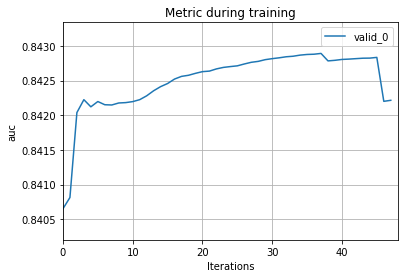

In [34]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='auc')
# plt.show()

In [35]:
# [50]	valid_0's auc: 0.838309

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

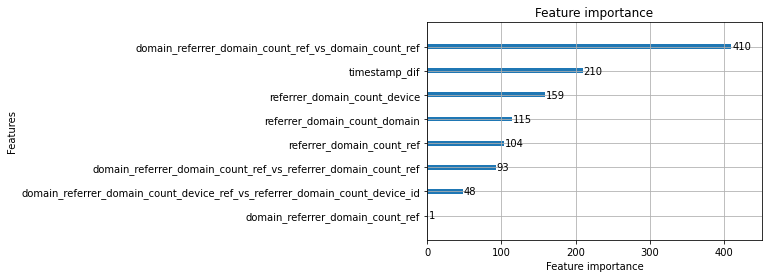

In [36]:
lgb.plot_importance(model)

In [37]:
train_test_features.dtypes[3:]

referrer_num                                                                    int64
timestamp_dif                                                                   int64
domain_count_ref                                                                int64
domain_count_device                                                             int64
domain_count_referrer_domain                                                    int64
referrer_domain_count_ref                                                       int64
referrer_domain_count_device                                                    int64
referrer_domain_count_domain                                                    int64
domain_referrer_domain_count_ref                                                int64
domain_referrer_domain_count_device                                             int64
domain_referrer_domain_count_ref_vs_domain_count_ref                          float64
domain_referrer_domain_count_ref_vs_referrer_domain_co

In [38]:
train_test_pred = train_test_features[['referrer_num', 'is_referrer']].copy()
train_test_pred['is_referrer_pred'] = model.predict(get_x(train_test_features))
train_test_pred = train_test_pred.pivot(columns='referrer_num', values=['is_referrer', 'is_referrer_pred'])
train_test_pred.head()

is_referrer                                                   \
referrer_num             0      1      2      3      4      5      6      7   
event_group_id                                                                
7                    False  False  False  False  False  False   True  False   
9                    False  False  False  False  False  False  False  False   
13                   False  False  False  False  False  False  False  False   
16                   False  False  False   True  False  False  False  False   
31                   False  False  False  False  False  False  False  False   

                             is_referrer_pred                                \
referrer_num        8      9                0         1         2         3   
event_group_id                                                                
7               False  False         0.075054  0.068542  0.068542  0.068542   
9               False   True         0.068542  0.068542  0.068542  0.068542   
13              False   True         0.068542  0.068542  0.068542  0.068542   
16              False  False         0.068542  0.068542  0.068542  0.182016   
31               True  False         0.068542  0.080196  0.068542  0.080196   

                                                                            
referrer_num           4         5         6         7         8         9  
event_group_id                                                              
7               0.068542  0.068542  0.182981  0.068542  0.325332  0.068542  
9               0.071893  0.068542  0.068542  0.088434  0.068542  0.348622  
13              0.068542  0.068542  0.068542  0.068542  0.068542  0.068542  
16              0.068542  0.068542  0.068542  0.068542  0.125087  0.068542  
31              0.068542   0.08825   0.08141  0.068542  0.137396  0.068542

In [39]:
f1_score(np.argmax(train_test_pred.iloc[:,:10].values, axis=1), np.argmax(train_test_pred.iloc[:,10:20].values, axis=1), average='macro')

0.58151635040473

In [ ]:
# auc: 0.842891 private: 0.58151635040473 public: 0.577699280352

In [40]:
# Prediction

In [41]:
test_data = pd.read_csv(data_path_test_orig)

In [ ]:
test_data.head(11)

,event_group_id,device_id,timestamp,domain,url,referrer_num
0,463817,300000,1171269282,ttgxZm.gC,ttgxZm.gC/jjjvdN/jdSNxb,0
1,463817,300000,1171269968,ttTzuL.jl,ttTzuL.jl/jllpZL,1
2,463817,300000,1171270289,ttNggB.jg,tWAmxZ.ttNggB.jg/jHSjLY,2
3,463817,300000,1171270295,ttLfvM.MK,ttLfvM.MK/jHLYjz/jvKLdf,3
4,463817,300000,1171270350,tWvuGv.jl,tWvuGv.jl/jvjiUY/jvBGiW/jHLXvg,4
5,463817,300000,1171270354,ttCnXo.QT,ttCnXo.QT/jljFFd/jdLLdr,5
6,463817,300000,1171270542,ttNggB.jg,tWAmxZ.ttNggB.jg/jHSjLY,6
7,463817,300000,1171270557,ttMJoz.AV,ttMJoz.AV/jCUFxs/jdSNxb,7
8,463817,300000,1171270618,ttCVLL.jg,tWAmxZ.ttCVLL.jg/jjSQNC,8
9,463817,300000,1171270625,ttJsFq.AV,ttJsFq.AV/jjXUzg/jdSNxb,9


In [48]:
test_data['is_referrer'] = False
test_data.head(11)

,event_group_id,device_id,timestamp,domain,url,referrer_num,is_referrer
0,463817,300000,1171269282,ttgxZm.gC,ttgxZm.gC/jjjvdN/jdSNxb,0,False
1,463817,300000,1171269968,ttTzuL.jl,ttTzuL.jl/jllpZL,1,False
2,463817,300000,1171270289,ttNggB.jg,tWAmxZ.ttNggB.jg/jHSjLY,2,False
3,463817,300000,1171270295,ttLfvM.MK,ttLfvM.MK/jHLYjz/jvKLdf,3,False
4,463817,300000,1171270350,tWvuGv.jl,tWvuGv.jl/jvjiUY/jvBGiW/jHLXvg,4,False
5,463817,300000,1171270354,ttCnXo.QT,ttCnXo.QT/jljFFd/jdLLdr,5,False
6,463817,300000,1171270542,ttNggB.jg,tWAmxZ.ttNggB.jg/jHSjLY,6,False
7,463817,300000,1171270557,ttMJoz.AV,ttMJoz.AV/jCUFxs/jdSNxb,7,False
8,463817,300000,1171270618,ttCVLL.jg,tWAmxZ.ttCVLL.jg/jjSQNC,8,False
9,463817,300000,1171270625,ttJsFq.AV,ttJsFq.AV/jjXUzg/jdSNxb,9,False


In [46]:
test_features = process(test_data)
test_features = process_features(test_features)

In [ ]:
test_pred = test_features[['referrer_num', 'is_referrer']].copy()
test_pred['is_referrer_pred'] = model.predict(get_x(test_features))
test_pred = test_pred.pivot(columns='referrer_num', values=['is_referrer', 'is_referrer_pred'])
test_pred.head()

is_referrer                                                   \
referrer_num             0      1      2      3      4      5      6      7   
event_group_id                                                                
1                    False  False  False  False  False  False  False  False   
4                    False  False  False  False  False  False  False  False   
5                    False  False  False  False  False  False  False  False   
8                    False  False  False  False  False  False  False  False   
12                   False  False  False  False  False  False  False  False   

                             is_referrer_pred                                \
referrer_num        8      9                0         1         2         3   
event_group_id                                                                
1               False  False         0.068542  0.068542  0.068542  0.249763   
4               False  False         0.068542  0.068542  0.121963  0.126049   
5               False  False         0.068542  0.068542  0.068542  0.341002   
8               False  False         0.068542  0.068542  0.068542  0.068542   
12              False  False         0.068542  0.068542  0.068542  0.068542   

                                                                            
referrer_num           4         5         6         7         8         9  
event_group_id                                                              
1               0.242325  0.068542  0.068542  0.068542  0.068542  0.068542  
4               0.068542  0.068542  0.068542  0.068542  0.068542  0.068542  
5               0.068542  0.068542  0.068542  0.068542  0.068542  0.068542  
8               0.068542  0.068542  0.068542  0.068542  0.068542  0.068542  
12              0.068542  0.081666  0.068542  0.068542  0.068542  0.068542

In [58]:
test_pred['referrer_num'] = np.argmax(test_pred.iloc[:,10:].values, axis=1)

In [62]:
test_pred[['referrer_num']].reset_index().to_csv('result_v1.csv', index=False)

In [52]:
sample = pd.read_csv(data_path_sample_orig)
sample

,event_group_id,referrer_num
0,1,3
1,4,3
2,5,3
3,8,8
4,12,8
...,...,...
552494,1737999,9
552495,1738003,2
552496,1738006,8
552497,1738008,9
